In [1]:
import json
import web3
import ipdb
import os

#from web3 import Web3
from web3 import Web3, HTTPProvider
from solc import compile_source
from web3.contract import ConciseContract

import pandas as pd
import time
import random

import numpy as np

data = pd.read_csv("Llaves.csv") 

public_keys = data['Llave Publica']
private_keys = data['Llave Privada']

w3 = Web3(HTTPProvider("https://rinkeby.infura.io/v3/4c0ec7f1412a489d91e1934c66ebf5b1"))

## Smart Contracts

In [26]:
## Coops

Coops_abi = open("./abi/Coops.json", "r")
c_values = json.load(Coops_abi)
Coops_abi.close()
coops = w3.eth.contract(
    address = '0x2c66b176962911D2ce40f5809cD52C73c8E78356',
    abi = c_values,
)

## Propietarios

Propietarios_abi = open("./abi/Propietarios.json", "r")
o_values = json.load(Propietarios_abi)
Propietarios_abi.close()
propietarios = w3.eth.contract(
    address = '0xD5fbF619121824aCB4e7aAf66A1d86947CE87f1B',
    abi = o_values,
)

## Proveedores

Proveedores_abi = open("./abi/Proveedores.json", "r")
v_values = json.load(Proveedores_abi)
Proveedores_abi.close()
proveedores = w3.eth.contract(
    address = '0x71eCEF369c041955C9993c635144a629c82CcD86',
    abi = v_values,
)

## Instaladores

Instaladores_abi = open("./abi/Instaladores.json", "r")
i_values = json.load(Instaladores_abi)
Instaladores_abi.close()
instaladores = w3.eth.contract(
    address = '0xC0ed1D311963EFc99418C0C84Ff2661CF199f9b0',
    abi = i_values
)

## Gestores

Gestores_abi = open("./abi/Gestores.json", "r")
m_values = json.load(Gestores_abi)
Gestores_abi.close()
gestores = w3.eth.contract(
    address = '0x23215E9FFaE52Eaf79c861d4F620A9748f3652C1',
    abi = m_values
)

## CF

CF_abi = open("./abi/CF.json", "r")
cf_values = json.load(CF_abi)
CF_abi.close()
cf = w3.eth.contract(
    address = '0x4Bac31B5056b1975D286d552F64F7962b8f2b2cc',
    abi = cf_values
)

## Proyectos

Proyectos_abi = open("./abi/Proyectos.json", "r")
p_values = json.load(Proyectos_abi)
Proyectos_abi.close()
proyectos = w3.eth.contract(
    address = '0x05c24902c594c255E4d2FA9B5D8ca7c1d44A7E85',
    abi = p_values
)

## Matching (off-chain)

In [23]:
def match(public_keys,private_keys): 
    i_interest_rate = proyectos.call().interest_rate()
    i_demands = propietarios.call().getUserCount()
    for i_demand in range(i_demands):
        address_d = propietarios.call().getUserAtIndex(i_demand)
        b_funding = propietarios.call().getFunding(address_d)
        i_MaxPrice = propietarios.call().getDemand(address_d)
        i_vendors = proveedores.call().getProvidersCount()
        for i_vendor in range(i_vendors):
            address_v = proveedores.call().getProviderAtIndex(i_vendor)
            i_price_v = proveedores.call().getProvider(address_v)
            i_installers = instaladores.call().getInstallersCount()
            for i_installer in range(i_installers):
                address_i = instaladores.call().getInstallerAtIndex(i_installer)
                i_price_i = instaladores.call().getInstaller(address_i)
                i_managers = gestores.call().getManagersCount()
                for i_manager in range(i_managers): 
                    address_m = gestores.call().getManagerAtIndex(i_manager)
                    i_price_m = gestores.call().getManager(address_m)

                    i_projectcost = int((i_price_v + i_price_i + i_price_m)*(100+i_interest_rate)/100)
                    if i_projectcost <= i_MaxPrice:
                        if b_funding == False:
                            print('Project Cost = '+str(i_projectcost))
                            acct = w3.eth.account.privateKeyToAccount(private_keys[0])
                            construct_txn = proyectos.functions.Matching(address_d,address_v,
                                                                         address_i,address_m).buildTransaction({
                                'from': acct.address,
                                'nonce': w3.eth.getTransactionCount(acct.address),
                                'gasPrice': w3.toWei('1.4', 'gwei')})

                            signed = acct.signTransaction(construct_txn)

                            tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

                            # Wait for the transaction to be mined, and get the transaction receipt
                            tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
                            return (tx_receipt,b_funding)


                        elif b_funding == True:
                            print(i_projectcost)
                            acct = w3.eth.account.privateKeyToAccount(private_keys[0])
                            construct_txn = cf.functions.Crowdsale(address_d,address_v,address_i,
                                                                   address_m,1).buildTransaction({
                                'from': acct.address,
                                'nonce': w3.eth.getTransactionCount(acct.address),
                                'gas': 3000000,
                                'gasPrice': w3.toWei('1.4', 'gwei')})

                            signed = acct.signTransaction(construct_txn)
                            tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
                            tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
                            
                            return (tx_receipt,b_funding)
                        
    print('No match found')
    return False
                    


## Limpiar deudas

In [ ]:
for i in range(1,len(public_keys)):
    totaldebt = coops.call().getTotalDebt(public_keys[i])
    print('Debt of '+public_keys[i]+' = '+str(totaldebt)+ '  Coops')
    if totaldebt > 0:
        acct = w3.eth.account.privateKeyToAccount(private_keys[i])
        for address in public_keys:
            debt = coops.call().getDebt(acct.address,address)
            if debt > 0: 
                construct_txn = coops.functions.Pay(address,debt).buildTransaction({
                    'from': acct.address,
                    'nonce': w3.eth.getTransactionCount(acct.address),
                    'gas': 3000000,
                    'gasPrice': w3.toWei('1.4', 'gwei')})
                signed = acct.signTransaction(construct_txn)

                tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
                # Wait for the transaction to be mined, and get the transaction receipt
                tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
                print('Debt of '+acct.address+' = '+str(coops.call().getTotalDebt(acct.address))+ '  Coops')

## Devolver Coops

In [ ]:
for i in range(1,len(public_keys)):
    address = public_keys[i]
    balance = coops.call().balanceOf(address)
    if balance > 0:
        acct = w3.eth.account.privateKeyToAccount(private_keys[i])
        construct_txn = coops.functions.transfer(public_keys[0],balance).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gasPrice': w3.toWei('1.4', 'gwei')})

        signed = acct.signTransaction(construct_txn)

        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        
    print('Balance of '+address+' = '+str(coops.call().balanceOf(address))+ '  Coops')


## Repartir Coops

In [ ]:
i_addresses = 120
acct = w3.eth.account.privateKeyToAccount(private_keys[0])
balance = int(coops.call().balanceOf(public_keys[0])/(i_addresses)/2.6)
for i in range(1,i_addresses+1):
    address = public_keys[i]
    i_balance = int(coops.call().balanceOf(public_keys[i]))
    if i_balance == 0: 
        construct_txn = coops.functions.transfer(address,balance).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gas': 3000000,
            'gasPrice': w3.toWei('1.4', 'gwei')})
        signed = acct.signTransaction(construct_txn)

        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print('Balance of '+address+' = '+str(coops.call().balanceOf(address))+ '  Coops')

## CUD (Propietarios)

In [21]:
reference_price = 2190000
min_price = int(reference_price*0.4)
i_addresses = 120
totTransactions = 0
gas_newdemand = []
gas_editdemand = []
gas_deletedemand = []

for i in range(1,i_addresses+1):
    i_demands.append(totTransactions)
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])
    b_funding = bool(random.getrandbits(1))
    i_MaxPrice = random.randint(min_price,reference_price)
    if propietarios.call().isDemand(public_keys[i]) == False:
        construct_txn = propietarios.functions.newDemand(b_funding,i_MaxPrice).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gasPrice': w3.toWei('1', 'gwei')})

        signed = acct.signTransaction(construct_txn)

        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Gas used by New Demand = '+str(tx_receipt.gasUsed))
        gas_newdemand.append(tx_receipt.gasUsed)
        totTransactions += 1


for i in range(1,i_addresses+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])
    if propietarios.call().isDemand(public_keys[i]) == True:
        i_MaxPrice = random.randint(min_price,reference_price)
        b_funding = bool(random.getrandbits(1))
        construct_txn = propietarios.functions.updatemaxPrice(i_MaxPrice).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gasPrice': w3.toWei('1', 'gwei')})
        signed = acct.signTransaction(construct_txn)
        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Gas used by Update Demand = '+str(tx_receipt.gasUsed))
        gas_editdemand.append(tx_receipt.gasUsed)
        totTransactions += 1
        
        construct_txn = propietarios.functions.deleteDemand(acct.address).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gasPrice': w3.toWei('1', 'gwei')})
        signed = acct.signTransaction(construct_txn)
        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Gas used by Delete Demand = '+str(tx_receipt.gasUsed))
        gas_deletedemand.append(tx_receipt.gasUsed)
        totTransactions += 1

print('Total Txs = '+str(totTransactions))

gas_editdemand.reverse()
gas_deletedemand.reverse()


Gas used by New Demand = 60636
Gas used by New Demand = 76615
Gas used by New Demand = 76615
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 96415
Gas used by New Demand = 96415
Gas used by New Demand = 76487
Gas used by New Demand = 76615
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 66351
Gas used by New Demand = 66351
Gas used by New Demand = 76615
Gas used by New Demand = 96415
Gas used by New Demand = 76551
Gas used by New Demand = 76615
Gas used by New Demand = 96415
Gas used by New Demand = 96415
Gas used by New Demand = 76615
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Demand = 66351
Gas used by New Demand = 96415
Gas used by New Demand = 66351
Gas used by New Demand = 76615
Gas used by New Demand = 76615
Gas used by New Demand = 66351
Gas used by New Demand = 96415
Gas used by New Demand = 76551
Gas used

Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23041
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30558
Gas used by Delete Demand = 23073
Gas used by Update Demand = 30494
Gas used by De

## Matching s/Financiamiento

In [25]:
i_props = 30
i_provs = 30
i_insts = 30
i_gests = 30
i_projects = 30

b_funding = False
i_MaxPrice = 2000000
i_price_v = 1000000
i_price_i = 100000
i_price_m = 10000

gas_match = []

#===================Demand==========================
for i in range(1,i_props+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])
    if propietarios.call().isDemand(public_keys[i]) == False:
        construct_txn = propietarios.functions.newDemand(b_funding,i_MaxPrice).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gasPrice': w3.toWei('1', 'gwei')})

        signed = acct.signTransaction(construct_txn)

        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Gas used by New Demand = '+str(tx_receipt.gasUsed))

#===================VENDOR==========================
for i in range(i_props+1,i_props+i_provs+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])
    construct_txn = proveedores.functions.newProvider(i_price_v).buildTransaction({
        'from': acct.address,
        'nonce': w3.eth.getTransactionCount(acct.address),
        'gas': 3000000,
        'gasPrice': w3.toWei('1', 'gwei')})

    signed = acct.signTransaction(construct_txn)

    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print('Gas used by New Vendor = '+str(tx_receipt.gasUsed))

#===================INSTALLER==========================
for i in range(i_props+i_provs+1,i_props+i_provs+i_insts+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])
    construct_txn = instaladores.functions.newInstaller(i_price_i).buildTransaction({
        'from': acct.address,
        'nonce': w3.eth.getTransactionCount(acct.address),
        'gas': 3000000,
        'gasPrice': w3.toWei('1', 'gwei')})

    signed = acct.signTransaction(construct_txn)

    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print('Gas used by New Installer = '+str(tx_receipt.gasUsed))

#===================MANAGER==========================
for i in range(i_props+i_provs+i_insts+1,i_addresses+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])

    construct_txn = gestores.functions.newManager(i_price_m).buildTransaction({
        'from': acct.address,
        'nonce': w3.eth.getTransactionCount(acct.address),
        'gas': 3000000,
        'gasPrice': w3.toWei('1', 'gwei')})

    signed = acct.signTransaction(construct_txn)

    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print('Gas used by New Manager = '+str(tx_receipt.gasUsed))

print('Propietarios = '+str(propietarios.call().getUserCount()))
print('Proveedores = '+str(proveedores.call().getProvidersCount()))
print('Instaladores = '+str(instaladores.call().getInstallersCount()))
print('Gestores = '+str(gestores.call().getManagersCount()))

#===================MATCHING==========================

xmatch = match(public_keys,private_keys) 
while xmatch != False:
    tx_receipt = xmatch[0]
    gas_match.append(tx_receipt.gasUsed)
    print('Gas used by Matching = '+str(tx_receipt.gasUsed))
    xmatch = match(public_keys,private_keys)

gas_match.reverse()

Gas used by New Demand = 70836
Gas used by New Demand = 66351
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 66351
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 66351
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Demand = 66351
Gas used by New Demand = 66351
Gas used by New Demand = 66351
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 76551
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Demand = 66351
Gas used by New Demand = 66351
Gas used by New Demand = 76551
Gas used by New Vendor = 69881
Gas used by New Vendor = 75590
Gas used

MismatchedABI: ("The function 'newManager' was not found in this contract's abi. ", 'Are you sure you provided the correct contract abi?')

## Matching c/Financiamiento

In [34]:
i_props = 30
i_provs = 24
i_insts = 24
i_gests = 24
i_finan = 18
i_projects = 30

i_MaxPrice = 0
totalCost = 1

gas_matchf = []

while totalCost > i_MaxPrice:
    reference_price = 2190000
    min_price = int(reference_price*0.4)
    b_funding = True
    i_MaxPrice = random.randint(min_price,reference_price)

    reference_price = 2190000
    min_price = int(reference_price*0.1)
    i_price_v = random.randint(min_price,reference_price)

    reference_price = int(2190000*0.5)
    min_price = int(reference_price*0.2)
    i_price_i = random.randint(min_price,reference_price)

    reference_price = int(2190000*0.5)
    min_price = int(reference_price*0.1)
    i_price_m = random.randint(min_price,reference_price)

    i_txs = 0
    gas_used = 0

    prevCost = i_price_v + i_price_i + i_price_m
    fee = int(prevCost * proyectos.call().interest_rate() / 100)
    totalCost = prevCost + fee

print('Total Cost = '+str(totalCost))


#===================Demand==========================
for i in range(1,i_props+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])
    if propietarios.call().isDemand(public_keys[i]) == False:
        construct_txn = propietarios.functions.newDemand(b_funding,i_MaxPrice).buildTransaction({
            'from': acct.address,
            'nonce': w3.eth.getTransactionCount(acct.address),
            'gasPrice': w3.toWei('1', 'gwei')})

        signed = acct.signTransaction(construct_txn)

        tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

        # Wait for the transaction to be mined, and get the transaction receipt
        tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
        print('Gas used by New Demand = '+str(tx_receipt.gasUsed))

#===================VENDOR==========================
for i in range(i_props+1,i_props+i_provs+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])
    construct_txn = proveedores.functions.newProvider(i_price_v).buildTransaction({
        'from': acct.address,
        'nonce': w3.eth.getTransactionCount(acct.address),
        'gas': 3000000,
        'gasPrice': w3.toWei('1', 'gwei')})

    signed = acct.signTransaction(construct_txn)

    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print('Gas used by New Vendor = '+str(tx_receipt.gasUsed))

#===================INSTALLER==========================
for i in range(i_props+i_provs+1,i_props+i_provs+i_insts+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])
    construct_txn = instaladores.functions.newInstaller(i_price_i).buildTransaction({
        'from': acct.address,
        'nonce': w3.eth.getTransactionCount(acct.address),
        'gas': 3000000,
        'gasPrice': w3.toWei('1', 'gwei')})

    signed = acct.signTransaction(construct_txn)

    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print('Gas used by New Installer = '+str(tx_receipt.gasUsed))

#===================MANAGER==========================
for i in range(i_props+i_provs+i_insts+1,i_addresses+1):
    acct = w3.eth.account.privateKeyToAccount(private_keys[i])

    construct_txn = gestores.functions.newManager(i_price_m).buildTransaction({
        'from': acct.address,
        'nonce': w3.eth.getTransactionCount(acct.address),
        'gas': 3000000,
        'gasPrice': w3.toWei('1', 'gwei')})

    signed = acct.signTransaction(construct_txn)

    tx_hash = w3.eth.sendRawTransaction(signed.rawTransaction)

    # Wait for the transaction to be mined, and get the transaction receipt
    tx_receipt = w3.eth.waitForTransactionReceipt(tx_hash)
    print('Gas used by New Manager = '+str(tx_receipt.gasUsed))

print('Propietarios = '+str(propietarios.call().getUserCount()))
print('Proveedores = '+str(proveedores.call().getProvidersCount()))
print('Instaladores = '+str(instaladores.call().getInstallersCount()))
print('Gestores = '+str(gestores.call().getManagersCount()))

#===================MATCHING==========================

xmatch = match(public_keys,private_keys) 
while xmatch != False:
    if xmatch[1] == True:
        tx_receipt = xmatch[0]
        gas_matchf.append(tx_receipt.gasUsed)
        print('Gas used by Matching = '+str(tx_receipt.gasUsed))
        xmatch = match(public_keys,private_keys)
    
gas_matchf.reverse()

## Plot

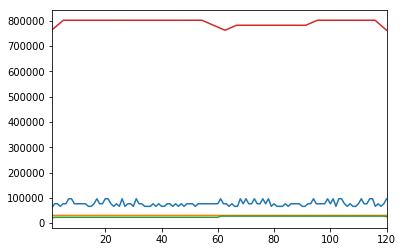

In [37]:
n = np.linspace(1,120,120)
n4 = np.linspace(1,120,30)
import matplotlib.pyplot as plt
plt.plot(n,gas_newdemand)
plt.plot(n,gas_editdemand)
plt.plot(n,gas_deletedemand)
plt.plot(n4,gas_match)
#for i in range(1,41):
 #   plt.plot(t[0:13],balances[i,:])
plt.margins(x=0)

In [ ]:
for i in range(1,9):
    plt.plot(t[0:13],balances[i,:])
plt.margins(x=0)

In [ ]:
for i in range(9,17):
    plt.plot(t[0:13],balances[i,:])
plt.margins(x=0)

In [ ]:
for i in range(17,25):
    plt.plot(t[0:13],balances[i,:])
plt.margins(x=0)

In [ ]:
for i in range(25,33):
    plt.plot(t[0:13],balances[i,:])
plt.margins(x=0)

In [ ]:
for i in range(33,41):
    plt.plot(t[0:13],balances[i,:])
#plt.plot(t[0:13],balances[35,:])
plt.margins(x=0)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(t[0:12],balances[6,0:12],label='Propietario')
plt.plot(t[0:12],balances[15,0:12],label='Proveedor')
plt.plot(t[0:12],balances[20,0:12],label='Instalador')
plt.plot(t[0:12],balances[30,0:12],label='Gestor')
plt.plot(t[0:12],balances[33,0:12],label='Financiador')
plt.xlabel('Mes', fontsize=13)
plt.ylabel('Saldo [tokens]', fontsize=13)
#plt.legend()
plt.margins(x=0)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18),
          fancybox=True, shadow=True, ncol=5, fontsize=13)

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(t[0:12],balances[7,0:12],label='Propietario')
plt.plot(t[0:12],balances[10,0:12],label='Proveedor')
plt.plot(t[0:12],balances[23,0:12],label='Instalador')
plt.plot(t[0:12],balances[31,0:12],label='Gestor')
#plt.plot(t[0:12],balances[33,0:12],label='Financiador')
plt.xlabel('Mes', fontsize=13)
plt.ylabel('Saldo [tokens]', fontsize=13)
#plt.legend()
plt.margins(x=0)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18),
          fancybox=True, shadow=True, ncol=5, fontsize=13)